# YOLOv4 Deteksi Rambu on Webcam In Google Colab


In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
Yolov4 harus berjalan di environment darknet

In [2]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [3]:
# mengaktifkan GPU, OPENCV dan LIBSO 
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
# mem-build darknet sehingga bisa menjalankan darknet.py dan dependency lainnya.
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

## Download Aset Yolov4 Deteksi Rambu
Aset yang dipersiapkan adalah model training yang sudah dibuat (.weights), detail training data (.data), nama class datanya nya (classes.names) dan config darknet training (.cfg)

*tambahkan file classes.names pada /data 
*   prohibitory
*   danger
*   mandatory
*   other






In [4]:
!ls

3rdparty	DarknetConfig.cmake.in	libdarknet.so  scripts
backup		darknet_images.py	LICENSE        src
build		darknet.py		Makefile       uselib
build.ps1	darknet_video.py	net_cam_v3.sh  vcpkg.json
build.sh	data			net_cam_v4.sh  video_yolov3.sh
cfg		image_yolov3.sh		obj	       video_yolov4.sh
cmake		image_yolov4.sh		__pycache__    yolov4_backup
CMakeLists.txt	include			README.md
darknet		json_mjpeg_streams.sh	results


In [5]:
#download aset dari google drive
!gdown --id 1kNO8ankBJkcBjPZ5ae40ZqMiesmaX2kv

Downloading...
From: https://drive.google.com/uc?id=1kNO8ankBJkcBjPZ5ae40ZqMiesmaX2kv
To: /content/darknet/yolov4_backup-20210226T083340Z-001.zip
237MB [00:01, 215MB/s]


In [6]:
#unzip filenya dan hapus file zip
!unzip yolov4_backup-20210226T083340Z-001.zip
!rm -f yolov4_backup-20210226T083340Z-001.zip

Archive:  yolov4_backup-20210226T083340Z-001.zip
replace yolov4_backup/yolov4_train.data? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: yolov4_backup/yolov4_train.data  
replace yolov4_backup/yolov4_custom_test.cfg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: yolov4_backup/yolov4_custom_test.cfg  
replace yolov4_backup/yolov4_custom_train_best.weights? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: yolov4_backup/yolov4_custom_train_best.weights  


## Darknet for Python
Menjalankan darknet pada Pyhton

In [8]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("yolov4_backup/yolov4_custom_test.cfg", "yolov4_backup/yolov4_train.data", "yolov4_backup/yolov4_custom_train_best.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function untuk mendeteksi object pada gambar/image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # mendapatkan rasio object untuk menyesuaikan bounding box
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # menjalankan modelnya untuk di deteksi
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## Helper Functions
Function untuk menjalankan deteksi pada Javascript object

In [9]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Webcam Images
Program akan mencoba melakukan **Capture** pada webcam browser dan model Yolov4 akan mendeteksi object hasil capture. 

Capture webcam pada browser menggunakan Javascript lalu menjalankan Yolov4.

In [10]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


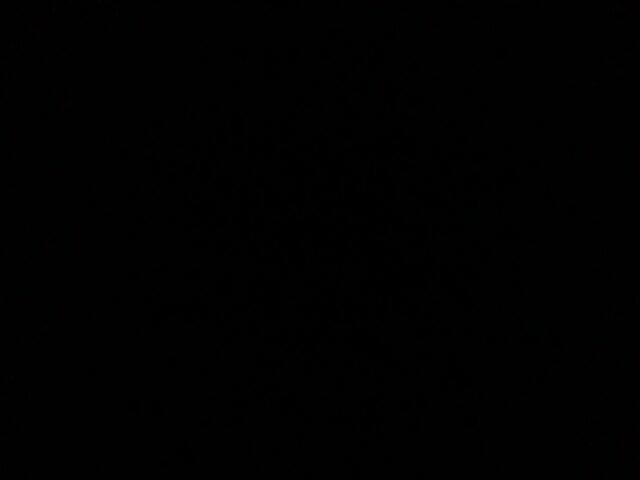

In [11]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Live Webcam Videos
Untuk live webcam Yolov4 ini sedikit kompleks dari capture. Perlu menyalakan video stream dan langsung mendeteksi object dengan Yolov4 tiap framenya. Bounding box juga akan langsung secara live (sedikit delay) terbentuk pada webcam.

Dibawah ini menggunakan Javascript untuk menyalakan video stream using sama dengan JavaScript untuk Capture. 

In [12]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [14]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## Tambahan
Cek akurasi model

rename folder /data ke /data1 dan buat folder baru pada /darknet bernama /data

In [7]:
import os
%cd data/
assert os.getcwd()=='/content/darknet/data', 'Directory should be "/content/darknet/data" instead of "{}"'.format(os.getcwd())

!wget --no-check-certificate "https://onedrive.live.com/download?cid=A86CBC7F31A1C06B&resid=A86CBC7F31A1C06B%21121&authkey=AMUUk0Np4tqH3n4" -O ts.zip
!unzip ts.zip
!rm -f ts.zip
%cd ..

/content/darknet/data
--2021-02-26 12:54:13--  https://onedrive.live.com/download?cid=A86CBC7F31A1C06B&resid=A86CBC7F31A1C06B%21121&authkey=AMUUk0Np4tqH3n4
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://sblnsa.db.files.1drv.com/y4mkb1qUbwOczZ_BZLZQEGRq6sI25Slw2JjpCraODRlC4xYCzy4T_aOxUbep5bF3nwD6cjhYopKbRlCr00PqHDuj1NhvHhhSB5_96mvHQOcvPIsOAJYw2cEXgo5w9rNQJ9Waw7CGc2LW9tPdoKs2DALCZs12x5uY6fHhBSo6AfBne36tt7qB3GfmeKlHaDd4jOOyj1baq0Gy1Cf8BtsRLKv1w/ts.zip?download&psid=1 [following]
--2021-02-26 12:54:14--  https://sblnsa.db.files.1drv.com/y4mkb1qUbwOczZ_BZLZQEGRq6sI25Slw2JjpCraODRlC4xYCzy4T_aOxUbep5bF3nwD6cjhYopKbRlCr00PqHDuj1NhvHhhSB5_96mvHQOcvPIsOAJYw2cEXgo5w9rNQJ9Waw7CGc2LW9tPdoKs2DALCZs12x5uY6fHhBSo6AfBne36tt7qB3GfmeKlHaDd4jOOyj1baq0Gy1Cf8BtsRLKv1w/ts.zip?download&psid=1
Resolving sblnsa.db.files.1drv.com (sblnsa.db.files

In [ ]:
assert os.getcwd()=='/content/darknet', 'Directory should be "/content/darknet" instead of "{}"'.format(os.getcwd())

!./darknet detector map yolov4_backup/yolov4_train.data yolov4_backup/yolov4_custom_test.cfg yolov4_backup/yolov4_custom_train_best.weights

#Sekian Implementasi Yolov4 pada Live Webcam